# setup and imports

In [363]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [364]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [365]:
rat_markers = {}
sequence = {}


# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
           'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
           'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
           'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
           'RatF42': (0.8, 0.2, 0.2), 'RatM40': (0.13, 0.55, 0.13), 'RatM43': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal'
               }

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[animal], markers[brainstatus[animal]], lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[palette[animal], markers[brainstatus[animal]], lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    # for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

    #     # get the preprocessed data from the pickle file
    #     biglesion = True if 'L' in session else False
    #     sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


# 1A schematic

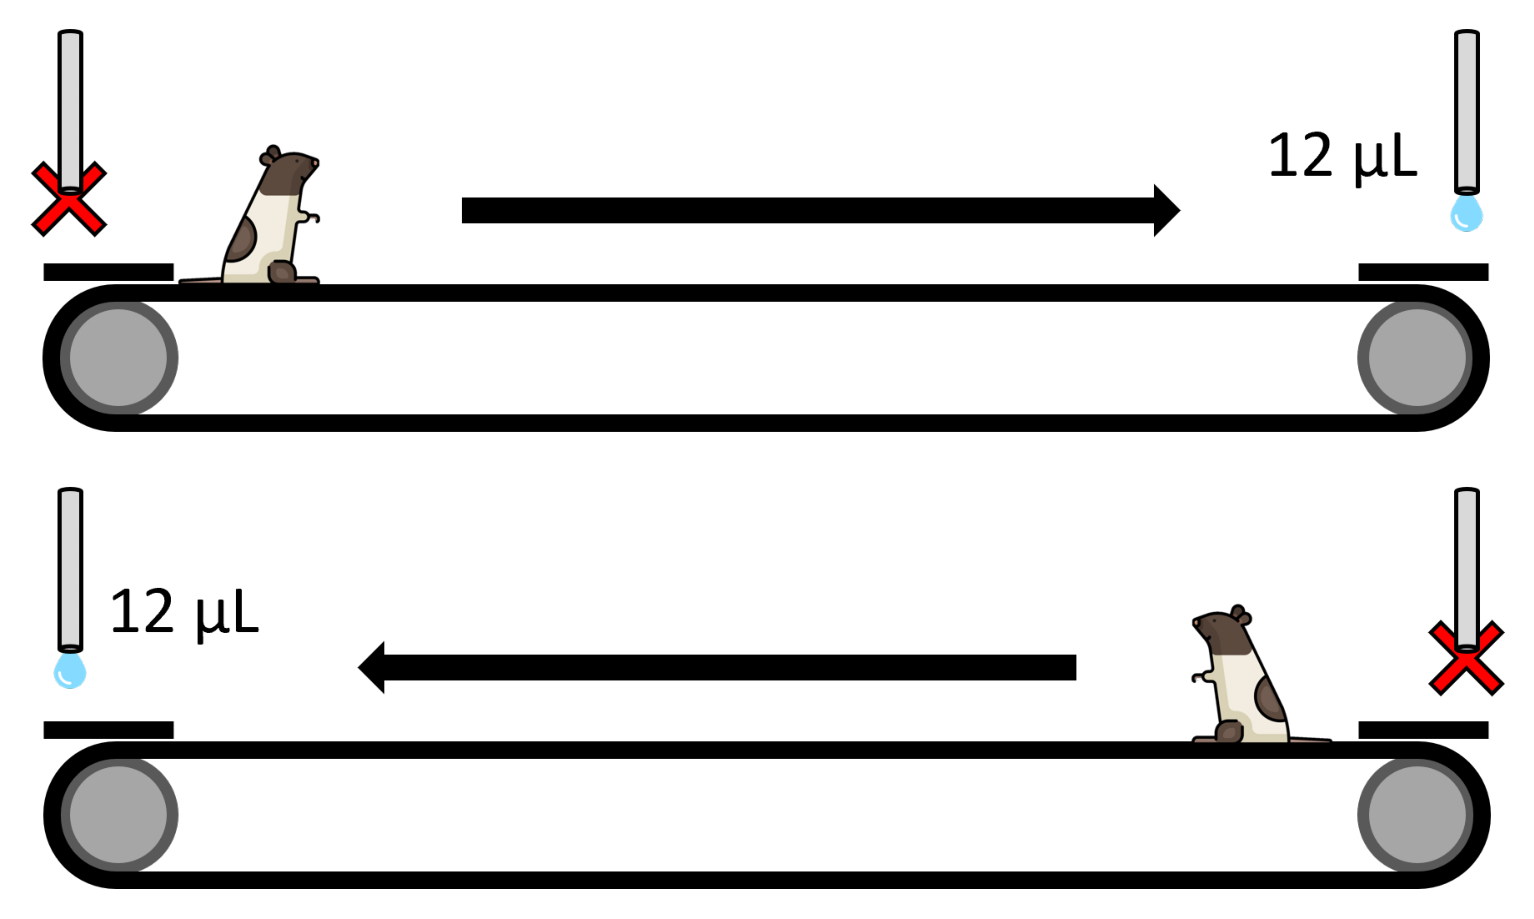

In [366]:
def Figure1A(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/Fig1A.png"

    img = plt.imread(path)
    ax.imshow(img)
    ax.axis("off")

Figure1A()

# 1B full track

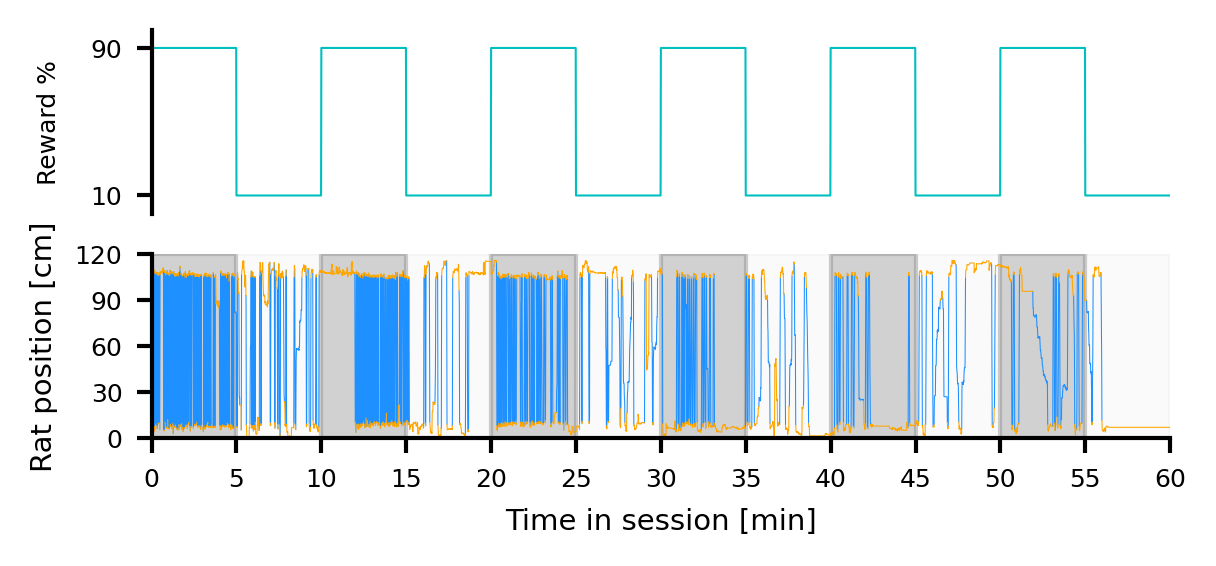

In [367]:
# plot session track without analysis files, session 120cm
def Figure1B(root="/home/david/Desktop/ALLDATA", 
            animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1],
                    color='grey', alpha=params['rewardProbaBlock'][i]/250,
                    # label=f'{params["rewardProbaBlock"][i]}% reward' if i == 0 or i == 1 else None
                    )

    ax.plot(time, running_Xs, color="dodgerblue", lw=.25)
    ax.plot(time, idle_Xs, color="orange", lw=.25)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 120)
    ax.set_xticks(np.arange(0, 3601, 300))
    ax.set_xticklabels(np.arange(0, 61, 5))
    ax.set_yticks(np.arange(0, 121, 30))
    ax.set_xlabel("Time in session [min]")
    ax.set_ylabel("Rat position [cm]")
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), ncol=1, fontsize=5)

    # for i in range(0, len(params['blocks'])):
    #     ax.text((params['blocks'][i][0]+params['blocks'][i][1])/2, 117, f'{params["rewardProbaBlock"][i]}%', ha='center', va='center', fontsize=4)



def Figure1Bbis(root="/home/david/Desktop/ALLDATA", 
            animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
            ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    params = get_from_pickle(root, animal, session, name="params.p")

    time = np.arange(0, 3600, 1)
    rewardProba = np.ones(3600)

    for t in range(0, len(time)):
        for i in range(0, len(params['blocks'])):
            if time[t] in range(params['blocks'][i][0], params['blocks'][i][1]):
                rewardProba[t] *= params['rewardProbaBlock'][i]

    ax.plot(time, rewardProba, color='c', lw=.5)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 100)
    ax.set_yticks([10, 90])
    ax.set_yticklabels(["10", "90"])
    ax.set_ylabel("Reward %", labelpad=7, fontsize=6)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


fig, axs = plt.subplots(2, 1, figsize = (cm2inch(10), cm2inch(4.5)), sharex=True)
Figure1B(ax=axs[1])
Figure1Bbis(ax=axs[0])

# 1C ZOOM

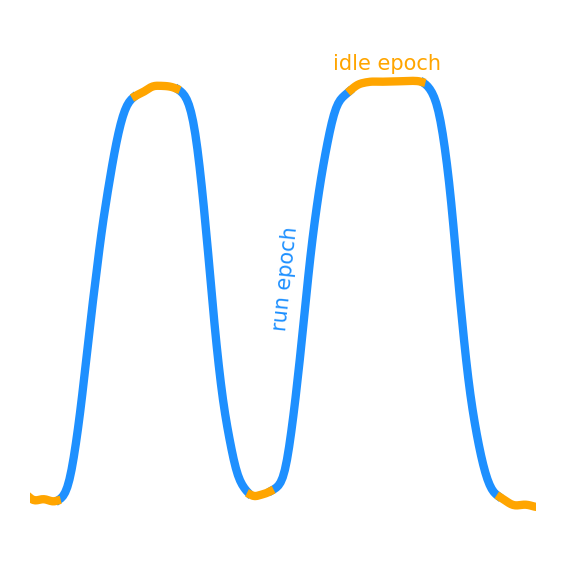

In [368]:
def Figure1C(root="/home/david/Desktop/ALLDATA", 
            animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    # for i in range(0, len(params['blocks'])):
    #     ax.axvspan(params['blocks'][i][0], params['blocks'][i][1],
    #                 color='grey', alpha=params['rewardProbaBlock'][i]/250,
    #                 label="%reward: " + str(params['rewardProbaBlock'][i])
    #                 if (i == 0 or i == 1) else "")

    ax.plot(time, running_Xs, label="run", color="dodgerblue", lw=2)
    ax.plot(time, idle_Xs, label="wait", color="orange", lw=2)

    ax.text(751.2, 112, 'idle epoch', ha="center", va="center", rotation=0, size=5, color='orange')
    ax.text(749.3, 61, 'run epoch', ha="center", va="center", rotation=84, size=5, color='dodgerblue')


    ax.set_xlim(744.5, 754)
    ax.set_ylim(0, 120)
    ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1C(ax=ax)

# 1D Run time 1 animal 

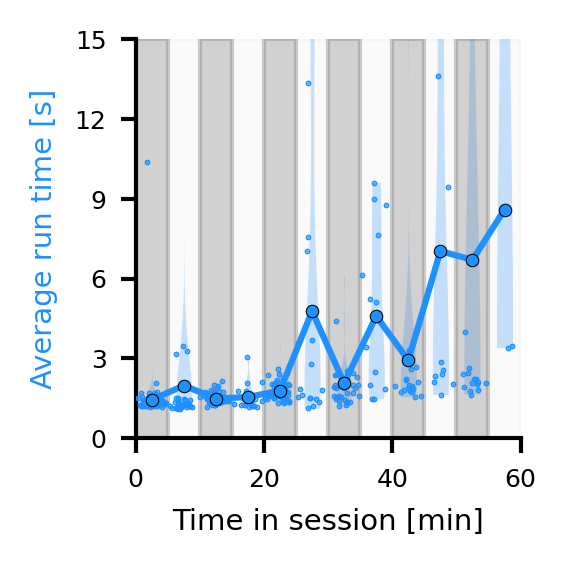

In [369]:
# plot variable median/mean fir each block
def Figure1D(root="/home/david/Desktop/ALLDATA", 
             animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    params = get_from_pickle(root, animal, session, name="params.p")
    blocks = params['blocks']
    rewardProbaBlock = params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    violin_parts = ax.violinplot(positions=[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                                 dataset=[data[i] for i in range(12)], widths=2.5, showextrema=False)
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('dodgerblue')
        vp.set_edgecolor('dodgerblue')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(1)
            vp.set_alpha(0.25)
        except:
            pass

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label="%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        ax.scatter(np.random.normal(((blocks[i][1] + blocks[i][0])/120), 1, len(data[i])), data[i], s=.15, color='dodgerblue', zorder=3)

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.mean(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.25)

    ax.set_xlabel("Time in session [min]")
    ax.set_ylabel("Average run time [s]", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 15)
    ax.set_yticks([0, 3, 6, 9, 12, 15])

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1D(ax=ax)

# 1E idle time 1 animal 

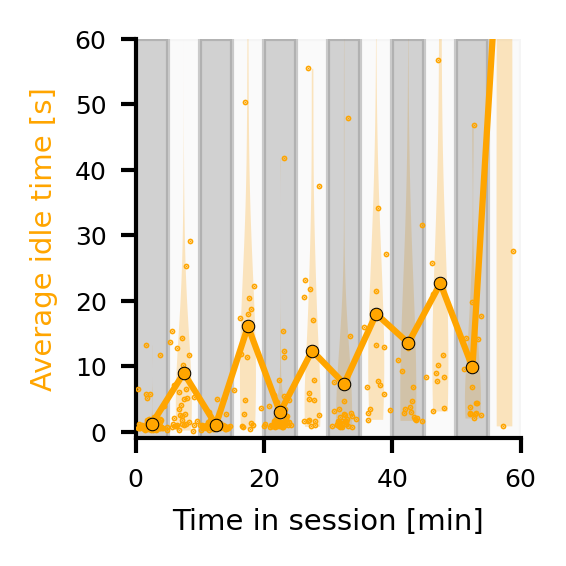

In [370]:
# plot idle time mean for each block
def Figure1E(root="/home/david/Desktop/ALLDATA", 
             animal='RatF02', session='RatF02_2021_07_22_18_14_16', 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    params = get_from_pickle(root, animal, session, name="params.p")
    blocks = params['blocks']
    rewardProbaBlock = params['rewardProbaBlock']
    example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
    data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

    violin_parts = ax.violinplot(positions=[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                                 dataset=[data[i] for i in range(12)], widths=2.5, showextrema=False)
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('orange')
        vp.set_edgecolor('orange')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(1)
            vp.set_alpha(0.25)
        except:
            pass

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label="%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        ax.scatter(np.random.normal(((blocks[i][1] + blocks[i][0])/120), 1, len(data[i])), data[i], s=.15, color='orange', zorder=3)

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.mean(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.25)

    ax.set_xlabel("Time in session [min]")
    ax.set_ylabel("Average idle time [s]", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(-1, 60)


fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1E(ax=ax)

# 1F run time all animals 



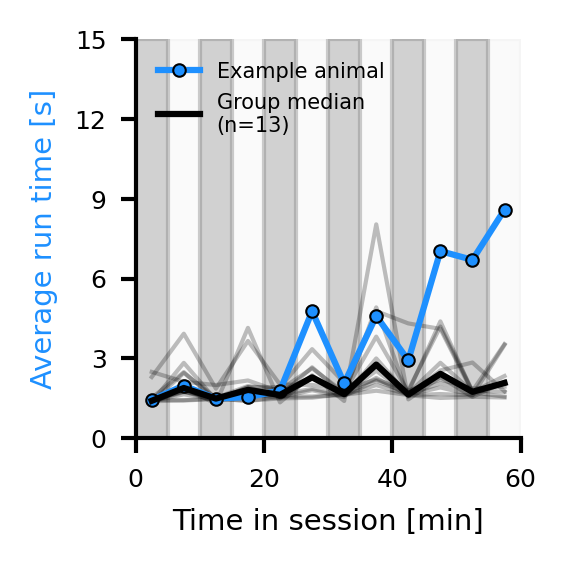

In [378]:
def Figure1F(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    median_all_animals = np.empty([len(animalList), 12])
    for idx, animal in enumerate(animalList):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

        if animal == 'RatF02':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.mean(data[i]) for i in range(0, len(blocks))],  # or use median
                marker='o', ms=3, color='dodgerblue', 
                zorder=4, markeredgecolor='k', markeredgewidth=0.5, label=f'Example animal')
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.mean(data[i]) for i in range(0, len(blocks))],
                color='k', lw=1,
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=0.25)
            
        median_all_animals[idx] = [np.mean(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25, 
            label=f'Group median\n(n={len(animalList)})')
    
    # ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
    #             np.nanmedian(median_all_animals, axis=0),
    #             yerr=stats.sem(median_all_animals, axis=0, nan_policy='omit'),
    #             color='k', lw=3, zorder=5, markeredgecolor='k', markeredgewidth=0.5)
    
    

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250)

    ax.set_xlabel("Time in session [min]")
    ax.set_ylabel("Average run time [s]", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 15)
    ax.set_yticks([0, 3, 6, 9, 12, 15])
    ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=False, fontsize=5)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1F(ax=ax)

# 1G idle time all animals 



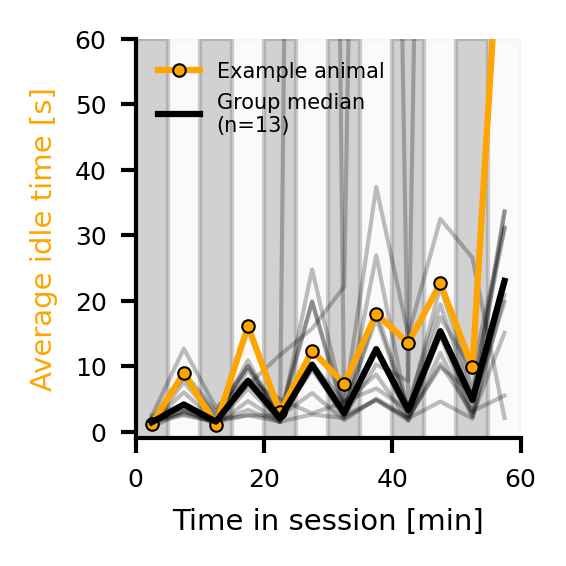

In [372]:
# plot idle time mean for each block
def Figure1G(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()
        
    median_all_animals = np.empty([len(animalList), 12])
    for idx, animal in enumerate(animalList):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

        if animal == 'RatF02':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.mean(data[i]) for i in range(0, len(blocks))],  # or use median
                marker='o', ms=3, color='orange', 
                zorder=4, markeredgecolor='k', markeredgewidth=0.5, label=f'Example animal')
            
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.mean(data[i]) for i in range(0, len(blocks))],
                linewidth=1, color='k', 
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=0.25)
    
        median_all_animals[idx] = [np.mean(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25, 
            label=f'Group median\n(n={len(animalList)})')
    
    # ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
    #         np.nanmedian(median_all_animals, axis=0),
    #         yerr=stats.sem(median_all_animals, axis=0, nan_policy='omit'),
    #         color='k', lw=3, zorder=5, markeredgecolor='k', markeredgewidth=0.5)
    

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250)
        
    ax.set_xlabel("Time in session [min]")
    ax.set_ylabel("Average idle time [s]", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(-1, 60)
    ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=False, fontsize=5)


fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1G(ax=ax)

# Figure 1

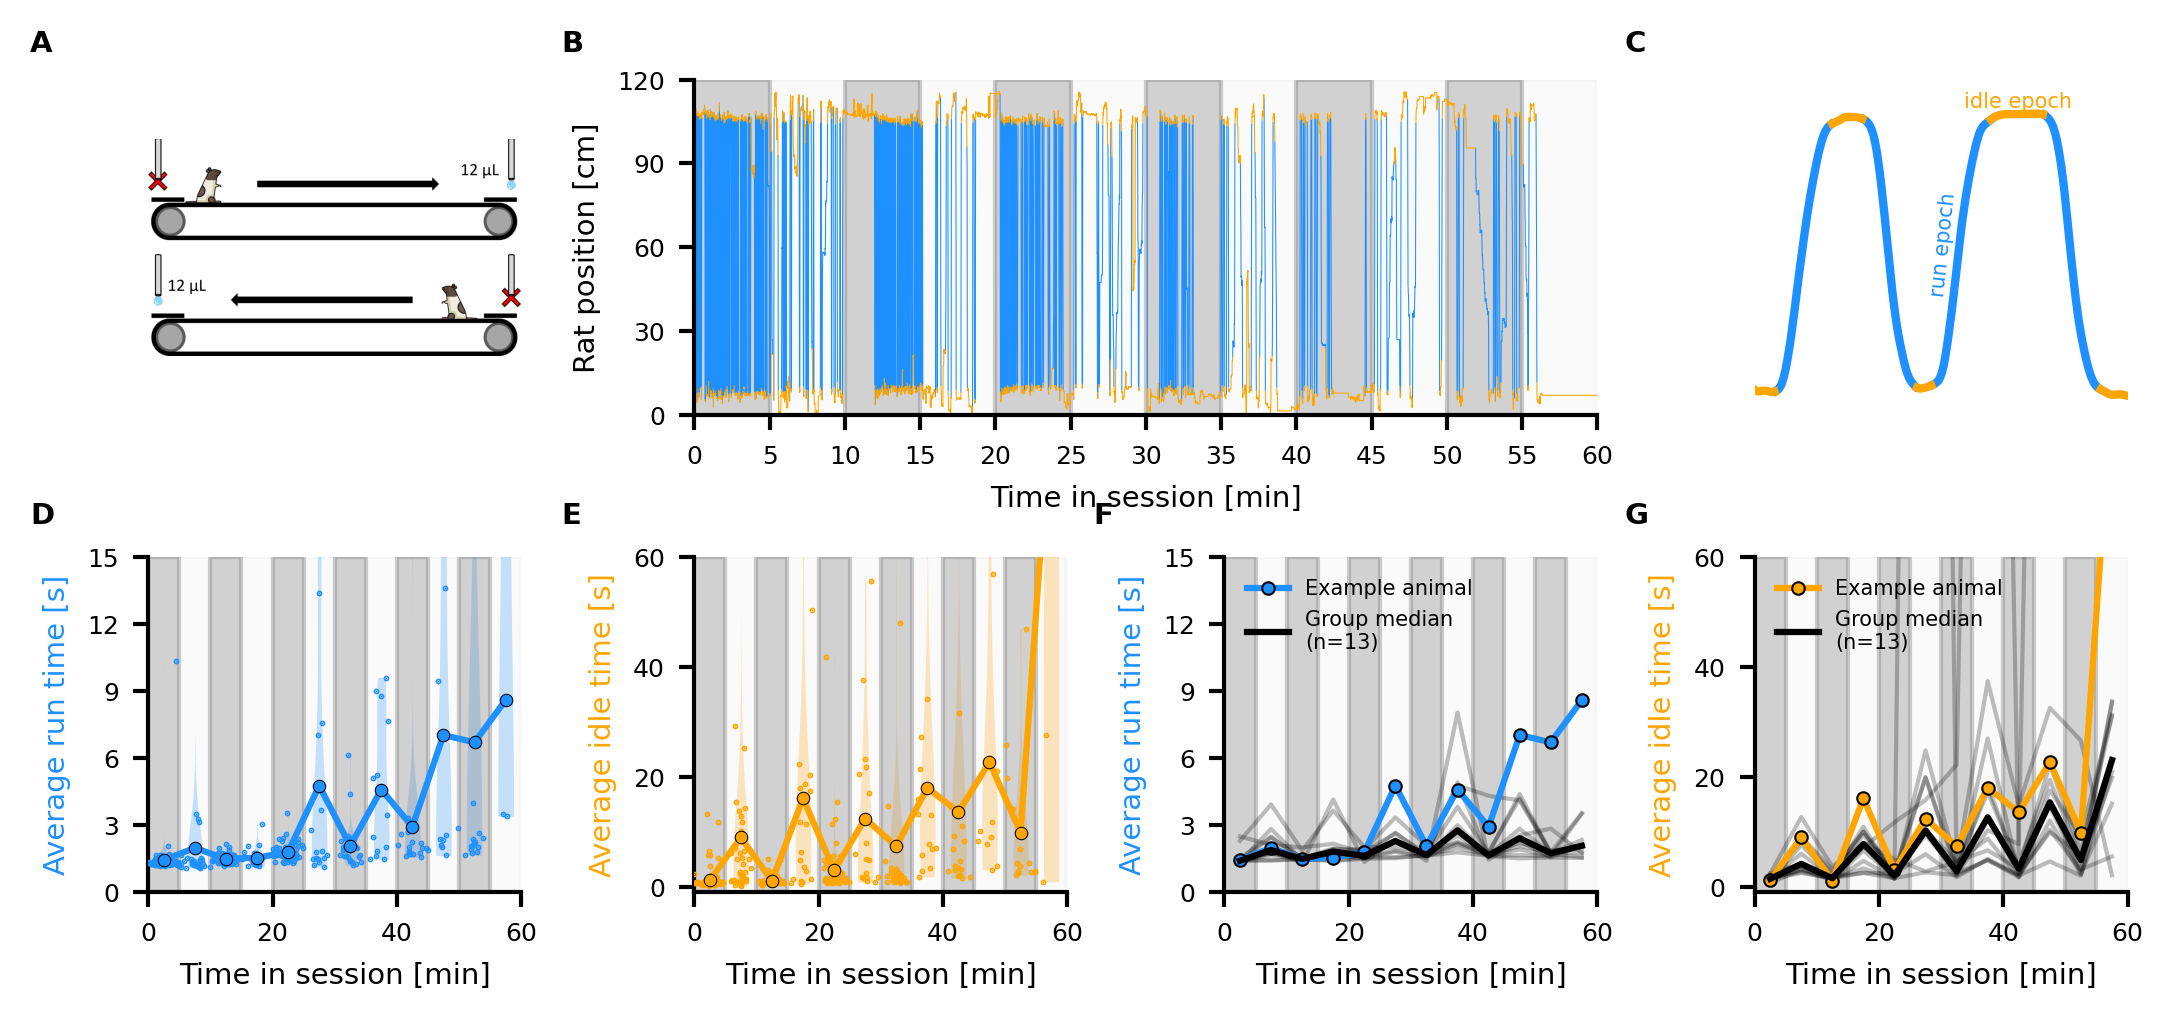

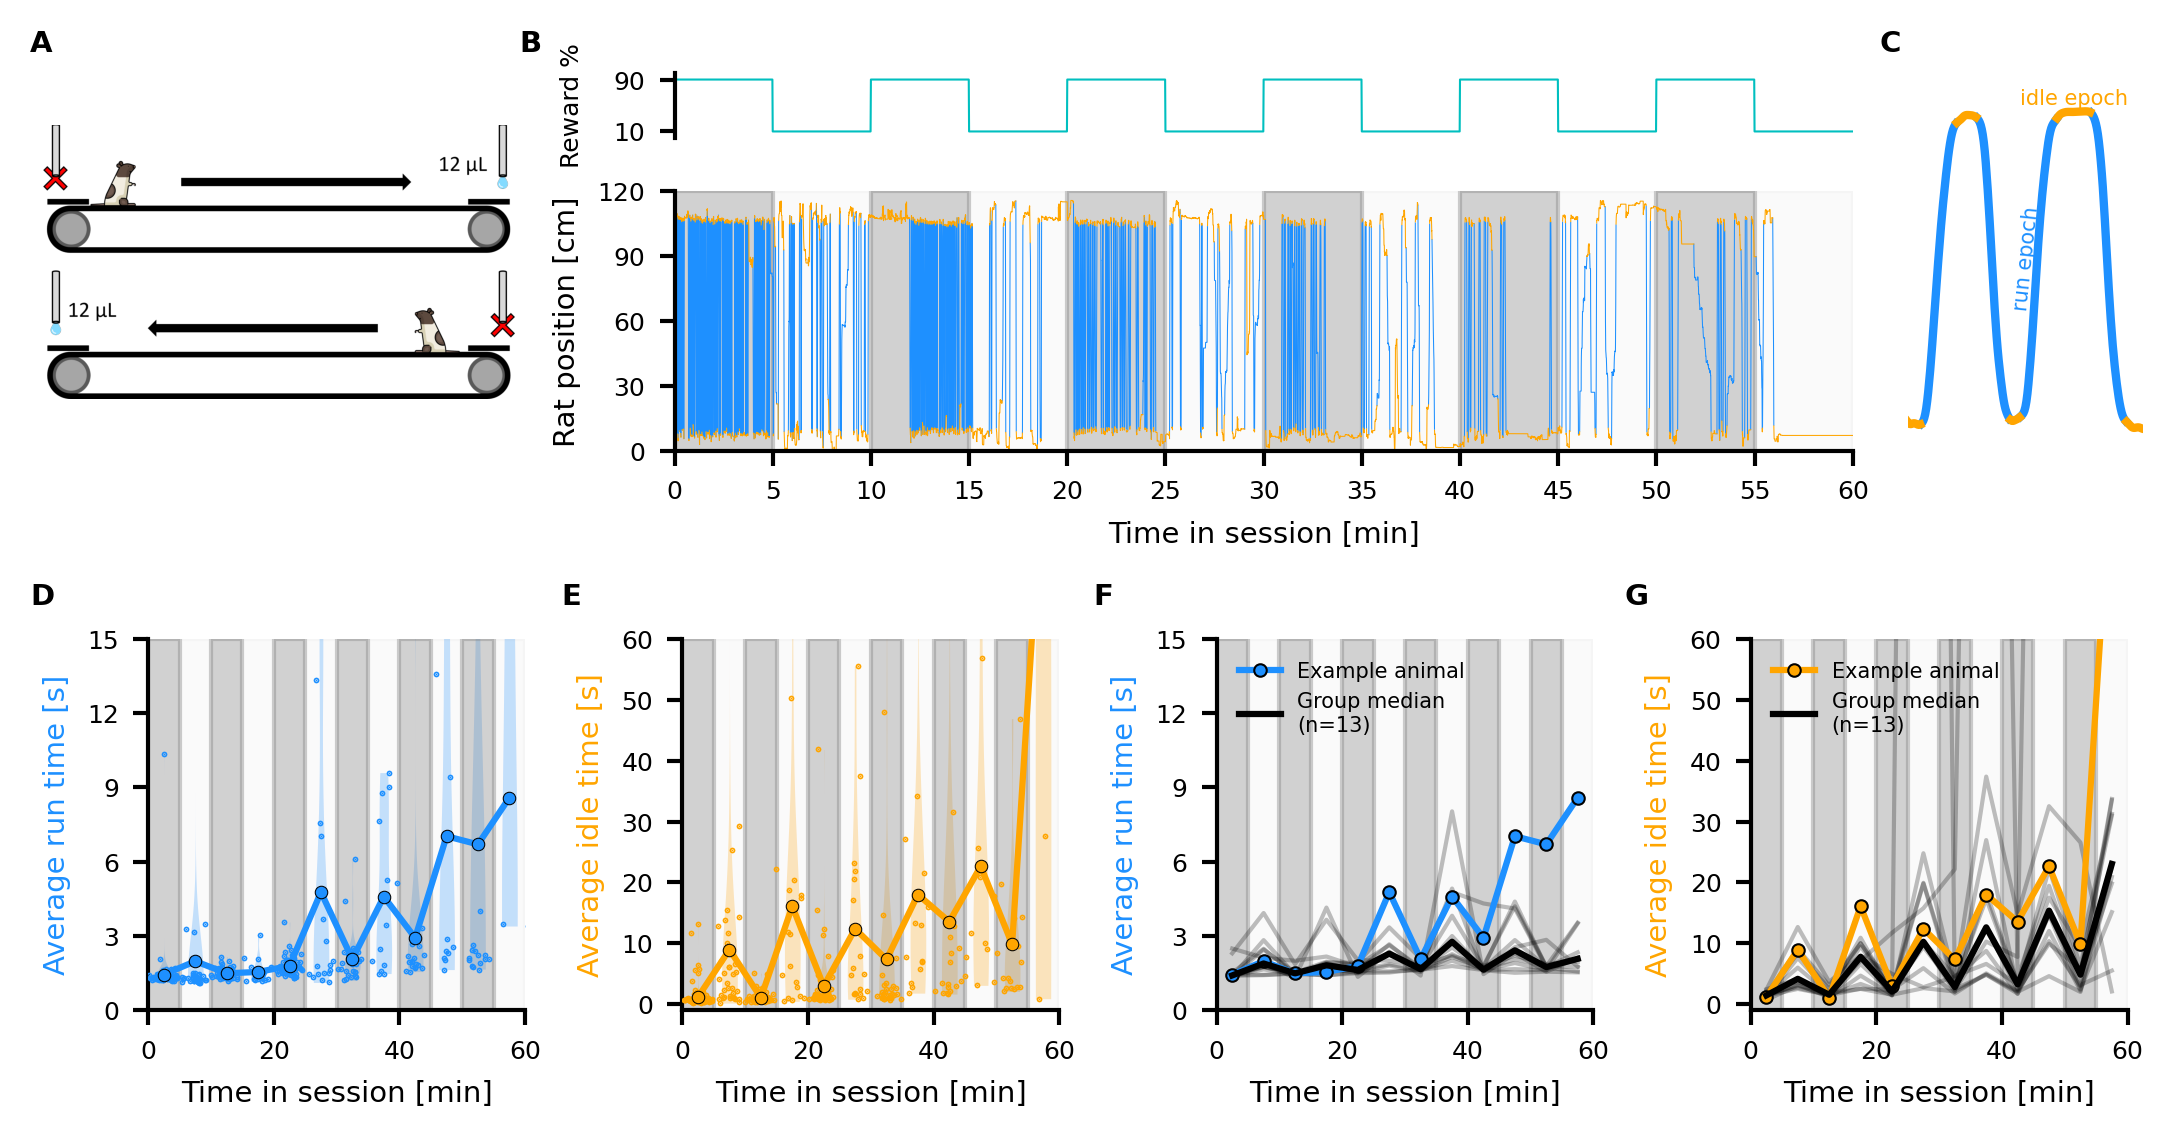

In [374]:

fig=plt.figure(figsize=(cm2inch(18), cm2inch(9)), dpi=300, constrained_layout=True)


gs0 = fig.add_gridspec(3, 1 , height_ratios=[9, 1, 9], hspace=0.5)

row1 = gs0[0].subgridspec(2, 3, 
                            wspace=0.5, 
                            hspace=0, 
                            height_ratios=[1, 4],
                            width_ratios=[2, 5, 1]
                            )

setup_schematic = plt.subplot(row1[:, 0])
raw_track_track = plt.subplot(row1[1, 1])
raw_track_proba = plt.subplot(row1[0, 1])
zoom_track = plt.subplot(row1[:, -1])

row2 = gs0[2].subgridspec(1, 4, 
                            wspace=.5, 
                            # hspace=2, 
                            # height_ratios=[1], 
                            width_ratios=[1, 1, 1, 1]
                            )

run_time_ex_rat = plt.subplot(row2[0, 0])
idle_time_ex_rat = plt.subplot(row2[0, 1])
run_time_all_rats = plt.subplot(row2[0, 2])
idle_time_all_rats = plt.subplot(row2[0, 3])

Figure1A(ax=setup_schematic)
Figure1B(ax=raw_track_track)
Figure1Bbis(ax=raw_track_proba)
Figure1C(ax=zoom_track)

Figure1D(ax=run_time_ex_rat)
Figure1E(ax=idle_time_ex_rat)
Figure1F(ax=run_time_all_rats)
Figure1G(ax=idle_time_all_rats)


figuresLabels={"A":[0.00, 1.00],
               "B":[0.23, 1.00],
               "C":[0.87, 1.00],
               "D":[0.00, 0.48],
               "E":[0.25, 0.48],
               "F":[0.50, 0.48],
               "G":[0.75, 0.48],
                }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

# old

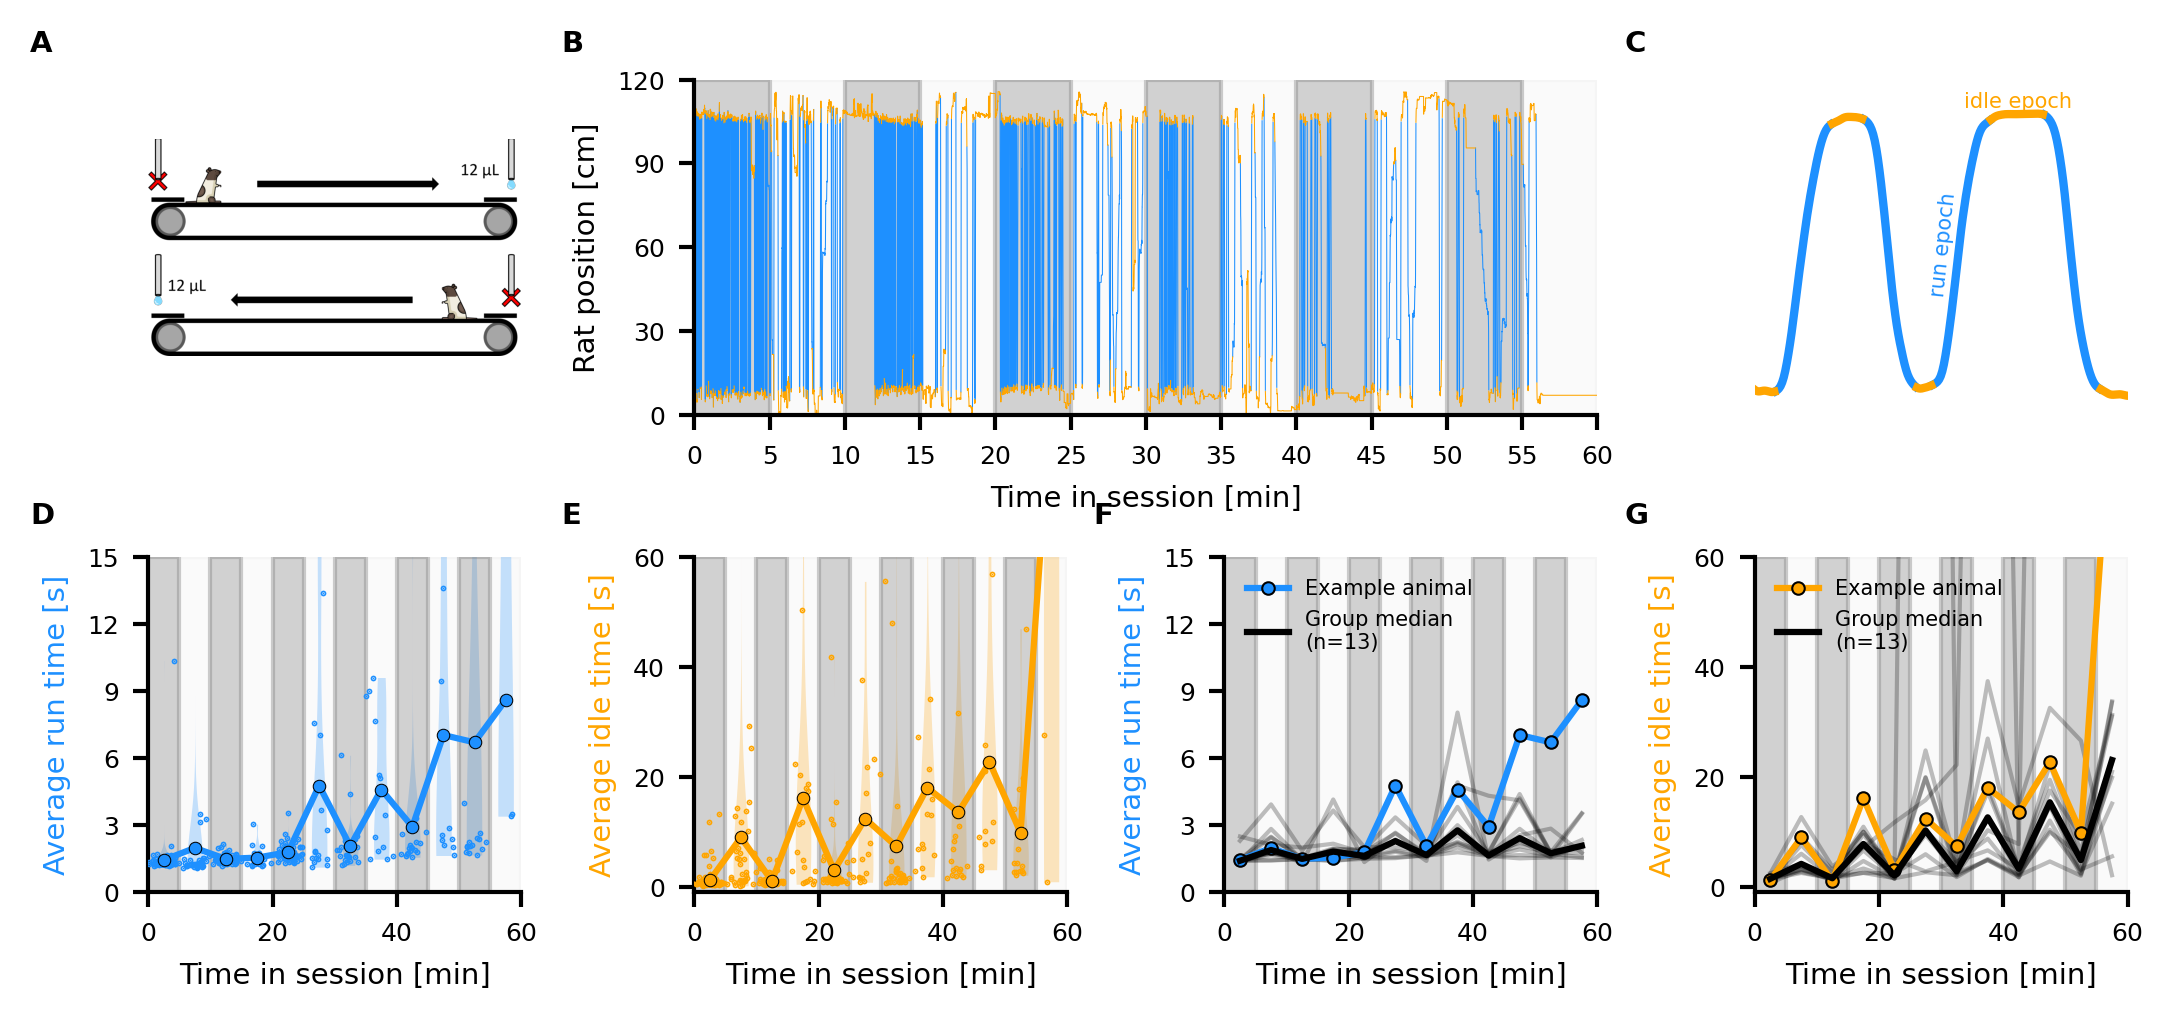

In [379]:
# empty gridspec 4 cols x 3 rows
fig = plt.figure(figsize=(cm2inch(18), cm2inch(8)), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

setup_schematic = fig.add_subplot(gs[0, 0])
raw_track = fig.add_subplot(gs[0, 1:3])
zoom_track = fig.add_subplot(gs[0, 3])

run_time_example_animal = fig.add_subplot(gs[1, 0])
idle_time_example_animal = fig.add_subplot(gs[1, 1])
run_time_all_animals = fig.add_subplot(gs[1, 2])
idle_time_all_animals = fig.add_subplot(gs[1, 3])

figuresLabels={
    "A":[0.00, 1.00],
               "B":[0.25, 1.00],
               "C":[0.75, 1.00],
               "D":[0.00, 0.50],
               "E":[0.25, 0.50],
               "F":[0.50, 0.50],
               "G":[0.75, 0.50],
                }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

Figure1A(ax=setup_schematic)
Figure1B(ax=raw_track)
Figure1C(ax=zoom_track)

Figure1D(ax=run_time_example_animal)
Figure1E(ax=idle_time_example_animal)
Figure1F(ax=run_time_all_animals)
Figure1G(ax=idle_time_all_animals)

# fig.tight_layout()
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()